# Project Milestone 2

## Tools

In [12]:
pip install pandas==1.0.5

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import nltk
import requests
import pickle
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from wordcloud import WordCloud
print('pandas version: ' + pd.__version__)

pandas version: 1.0.5


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
path_data = '/content/drive/MyDrive/Quotebank/'

In [16]:
# loop through nb_chunks_to_read chunks (if 0, through all chunks) and apply process_function to each of them
# return the result as a dataframe
def loop_chuncks(chunks, process_function, nb_chunks_to_read=0):
  i = 0
  result = []
  columns = None
  for chunk in chunks:
    processed = process_function(chunk)
    if processed is not None:
      if not isinstance(processed, pd.Series):
        columns = processed.columns
      for r in processed.values.tolist():
        result.append(r)
    i += 1
    if i == nb_chunks_to_read:
      break
  return pd.DataFrame(result, columns=columns)

In [17]:
# return the first 3 elements of a chunk
def chunck_head(chunk):
  return chunk.head(3)

# example
chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
loop_chuncks(chunks, chunck_head, 1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E


In [18]:
# to create automatically a list of synonyms
# https://towardsdatascience.com/synonyms-and-antonyms-in-python-a865a5e14ce8
nltk.download('wordnet')

def find_synonyms(word):
  words = []
  for syn in wordnet.synsets("warming"):
    for lm in syn.lemmas():
      words.append(lm.name())
  return words

# example
find_synonyms('climate')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['heating',
 'warming',
 'thaw',
 'thawing',
 'warming',
 'warm',
 'warm_up',
 'warm',
 'warming',
 'calefacient',
 'warming']

## Creation of the dataset about climate change

In [19]:
# return the quotes containing one of the words in the list

words = ['global warming', 'climate change']

def contains_word_in_list(chunk):
  return chunk[chunk.quotation.str.contains('|'.join(words))]

chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
word_in_list_quotes = loop_chuncks(chunks, contains_word_in_list, 3)

word_in_list_quotes.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
22,2020-03-18-024002,I gained a lot of knowledge on weather forecas...,Mizanur Rahman,"[Q6884592, Q6884595]",2020-03-18 15:38:41,1,"[[Mizanur Rahman, 0.8664], [None, 0.1336]]",[http://www.dhakatribune.com/climate-change/20...,E
41,2020-01-16-015615,Despite the fact that it includes very good la...,Charles Schumer,[Q380900],2020-01-16 17:02:47,1,"[[Charles Schumer, 0.6583], [None, 0.3394], [P...",[https://hypervocal.com/items/3180177],E
19,2020-02-19-062806,"People are ready for a bold platform, spurred ...",Steve Abel,[Q7611751],2020-02-19 07:28:48,1,"[[Steve Abel, 0.7744], [None, 0.2256]]",[http://auckland.scoop.co.nz/2020/02/greenpeac...,E


In [20]:
# to load and save pickes (from the course tutorial)
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(result, file_path = 'pickle'):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)

In [21]:
# create a pickle of the quotes about climate change for the 2020 dataset
# this have been done for the 6 datasets, commented to not re-run it (very long)
# chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
# climate_2020 = loop_chuncks(chunks, contains_word_in_list)
# path_pickle_2020 = '/content/drive/MyDrive/pickle_2020'
# save_pickle(word_in_list_quotes, path_pickle_2020)

In [22]:
# load the pickles
# the pickles need to be added to the drive
# download here: https://drive.google.com/drive/folders/1j1Bp1niC0_cqg1kN_LbSrA2TGnq5MTgt?usp=sharing
climate_2015 = load_pickle('/content/drive/MyDrive/pickle_2015')
climate_2016 = load_pickle('/content/drive/MyDrive/pickle_2016')
climate_2017 = load_pickle('/content/drive/MyDrive/pickle_2017')
climate_2018 = load_pickle('/content/drive/MyDrive/pickle_2018')
climate_2019 = load_pickle('/content/drive/MyDrive/pickle_2019')
climate_2020 = load_pickle('/content/drive/MyDrive/pickle_2020')
all_years_list = [climate_2015, climate_2016, climate_2017, climate_2018, climate_2019, climate_2020]
all_years = [2015, 2016, 2017, 2018, 2019, 2020]
for i in range(len(all_years)):
  all_years_list[i]['year'] = all_years[i]

In [23]:
# create one dataframe for all the years
climate_all_years = pd.concat(all_years_list, ignore_index=True)
print(climate_all_years.shape)
climate_all_years.sample(3)

(141512, 10)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,year
135650,2020-01-29-045799,I'm gon na support you if you win the nominati...,Ed Fallon,[Q5334792],2020-01-29 02:14:00,4,"[[Ed Fallon, 0.6269], [None, 0.2254], [Joe Bid...","[https://pjmedia.com/instapundit/356281/, http...",E,2020
83711,2018-05-01-004632,agree to join hands in offering innovative and...,None,[],2018-05-01 05:00:22,1,"[[None, 0.8608], [Narendra Modi, 0.1392]]",[https://www.thethirdpole.net/en/2018/05/01/ch...,E,2018
64544,2017-09-08-109462,The science is now fairly clear that climate c...,Michael Mann,"[Q1425193, Q1827335, Q1928511, Q270097, Q30276...",2017-09-08 00:00:00,93,"[[Michael Mann, 0.6853], [None, 0.258], [Micha...",[http://apr.org/post/hurricanes-are-sweeping-a...,E,2017


## First analyses

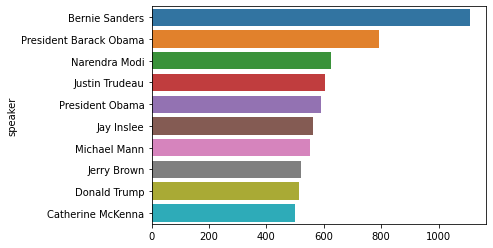

In [24]:
# the top speakers talking about climate change
top_speakers = climate_all_years.groupby(by='speaker').count().sort_values(by='quotation', ascending=False).quotation.iloc[1:21]
sns.barplot(x=top_speakers[:10].values, y=top_speakers[0:10].index)

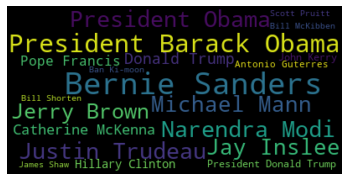

In [25]:
# word cloud of top speakers for illustration
wordcloud = WordCloud().fit_words(dict(top_speakers))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


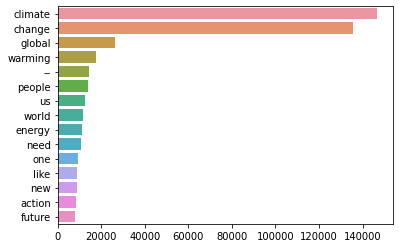

In [26]:
# words being most used in these quotes about global warming
nltk.download('stopwords')
topic_words = collections.Counter()
stop_words = set(stopwords.words('english'))
for index, row in climate_all_years.iterrows():
    for word in row.quotation.lower().replace(',', '').replace('.', '').split():
        if word not in stop_words:
            topic_words[word] += 1
top_50_climate_words = topic_words.most_common()[:50]
sns.barplot(x=[x[1] for x in top_50_climate_words][:15], y=[x[0] for x in top_50_climate_words][:15])

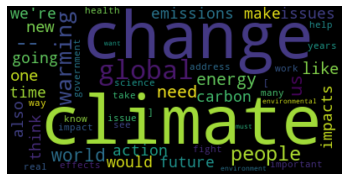

In [27]:
# word cloud for illustration
wordcloud = WordCloud().fit_words(dict(top_50_climate_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Quotations about global warming though time')

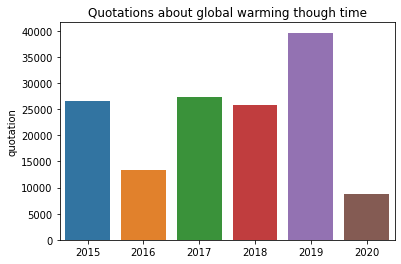

In [28]:
# number of quotations about global warming through the years
count_years =  climate_all_years.groupby(by='year').count().quotation
sns.barplot(x=all_years, y=count_years)
plt.title("Quotations about global warming though time")

## Tools for wikidata

In [29]:
# read the wikidata file
path_data_wikidata = '/content/drive/MyDrive/speaker_attributes.parquet/'
wikidata = pd.read_parquet(path_data_wikidata)
wikidata.head(3)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None


In [30]:
# to find the label of a QID
# from https://stackoverflow.com/questions/40268148/how-to-get-wikidata-labels-by-id-using-sparql

def find_QID_label(QID):
  url = 'https://query.wikidata.org/sparql'
  query = '''
  PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
  PREFIX wd: <http://www.wikidata.org/entity/> 
  SELECT  *
  WHERE {
          wd:%s rdfs:label ?label .
          FILTER (langMatches( lang(?label), "EN" ) )
        } 
  LIMIT 1
  ''' % (QID)
  result = requests.get(url, params = {'format': 'json', 'query': query})
  return result.json().get('results').get('bindings')[0].get('label').get('value')

# example
find_QID_label('Q161885')

'Great Britain'

In [31]:
# wikidata dataframe without the None name
wikidata_clean = wikidata.dropna(axis=0, subset=['aliases'])

In [32]:
# to find a speaker in the wikidata df
def find_speaker(speaker):
  return wikidata_clean[wikidata_clean.aliases.apply(lambda x: speaker in x[0])]

# example
find_speaker('Joseph Biden')

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
4529264,"[Joseph Biden, Joseph R. Biden, Joseph R. Bide...",[+1942-11-20T00:00:00Z],[Q30],[Q6581097],1395965219,None,B000444,"[Q82955, Q40348, Q1622272]",[Q29552],"[Q1540185, Q1765120]",Q6279,Joe Biden,"[Q22923830, Q7891450]",item,[Q1841]
7147986,"[Joseph Biden Sr., Joseph Robinette Biden Sr.]",[+1915-11-13T00:00:00Z],[Q30],[Q6581097],1393419215,None,None,None,None,None,Q20177093,Joseph R. Biden Sr.,None,item,None


## Nationalities

In [33]:
#Create a dataframe for the parquet information of the speakers
df = wikidata

In [34]:
df.head(10)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None
5,"[Augusto Pinochet Ugarte, Augusto José Ramón P...",[+1915-11-25T00:00:00Z],[Q298],[Q6581097],1392242213,None,None,"[Q189290, Q82955]",[Q327591],None,Q368,Augusto Pinochet,None,item,[Q1841]
6,"[Baudelaire, Charles Pierre Baudelaire-Dufaÿs,...",[+1821-04-09T00:00:00Z],[Q142],[Q6581097],1386699038,[Q121842],None,"[Q49757, Q4164507, Q11774202, Q333634, Q36180,...",None,None,Q501,Charles Baudelaire,None,item,[Q1841]
7,"[Mikołaj Kopernik, Nikolaus Kopernikus, Copern...",[+1473-02-19T00:00:00Z],[Q1649871],[Q6581097],1394975677,[Q1026],None,"[Q11063, Q185351, Q188094, Q170790, Q16012028,...",None,None,Q619,Nicolaus Copernicus,None,item,[Q1841]
8,"[Neil Percival Young, Shakey, Godfather of Gru...",[+1945-11-12T00:00:00Z],"[Q16, Q30]",[Q6581097],1395459626,None,None,"[Q177220, Q488205, Q2526255, Q639669, Q1881462...",None,None,Q633,Neil Young,None,item,None
9,None,[+1969-00-00T00:00:00Z],[Q183],[Q6581097],1340253739,None,None,"[Q33231, Q41546637]",None,None,Q640,Harald Krichel,None,item,None


In [35]:
#We will use only the 'nationality', 'id' and 'label' data from this dataframe
df = df[['nationality', 'label', 'id']]

#We are changing the 'None' value to an empty array
empty = pd.Series([[] for _ in range(len(df.index))], index=df.index)
df['nationality'] = df['nationality'].fillna(empty)

#Here, we are extracting the first nationality of every speaker, and changing the qid country code to -999
#for every speaker that did not have a specified nationality
df['nationality'] = df.nationality.apply(lambda x: x[0] if len(x) > 0 else 'Q-999')
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,nationality,label,id
0,Q161885,George Washington,Q23
1,Q145,Douglas Adams,Q42
2,Q31,Paul Otlet,Q1868
3,Q30,George W. Bush,Q207
4,Q29,Diego Velázquez,Q297
...,...,...,...
9055976,Q30,Barker B. Howard,Q106406560
9055977,Q30,Charles H. Macomber,Q106406571
9055978,Q-999,Dina David,Q106406588
9055979,Q-999,Irma Dexinger,Q106406593


In [36]:
df['nationality'].value_counts().head(20)

Q-999     5340129
Q30        430536
Q142       261891
Q183       249957
Q17        177541
Q145       162521
Q29        125935
Q9903      125906
Q38         95147
Q16         81559
Q34         78606
Q15180      76904
Q36         72444
Q29999      71745
Q155        69840
Q8733       65530
Q668        58211
Q20         55953
Q31         51919
Q408        51617
Name: nationality, dtype: int64